# PACE Tutorial 2: Analysing Missingness in Synthetic APC Data – Programmatic selection

## Introduction

This tutorial notebook builds on (`Tutorial Example.ipynb`), and takes another approach to analysing the data missingness from the same synthetic APC dataset.

In the previous tutorial, we used an interactive "Combination heatmap" visualization to select unexpected missingness combinations to analyse.

**Objectives for this tutorial:**
  - Learn how to select particular combinations of missingness programmatically with PACE (rather than interactively)
  - Explain unexpected patterns of missing data by using data mining techniques

## Preamble: PACE and other libraries

In [1]:
from pace.membership import *
from pace.history import *
from pace.plots import *

import pandas as pd
import numpy as np
from sklearn import tree, preprocessing

import graphviz

import matplotlib.pyplot as plt

## Load the data and create a PlotSession object

As before, we read the data as a Pandas dataframe, and create a PACE `PlotSession` object from it.

In [2]:
df = pd.read_csv("../../data/Synthetic_APC_DIAG_Fields.csv")

session = PlotSession(df)

From the `PlotSession` object, we can extract all distinct missingness combinations into a dataframe (here called `combinations`).

One row of this dataframe represents one unique combination which can be identified by its `intersection_id`.

Within a row, a boolean value in a column indicates if the column is missing (`True`) or not (`False`) in this particular combination.

We see that there are sixteen distinct missingness patterns in the data, including combination_id `0` with no missing fields.  We visualized these in the last tutorial (along with their count) with the **Combination heatmap** plot.

In [3]:
combinations = session.membership().intersections()
combinations

,DIAG_01,DIAG_02,DIAG_03,DIAG_04,DIAG_05,DIAG_06,DIAG_07,DIAG_08,DIAG_09,DIAG_10,ADMIAGE,ADMIMETH,Mortality,PROCODE3,SEX
intersection_id,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
3,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False
4,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False
5,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False
6,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False
7,False,False,False,True,True,True,True,True,True,True,False,False,False,False,False
8,False,False,True,False,False,False,True,True,True,False,False,False,False,False,False


> **Note**
>
> `PlotSession.membership()` returns an object containing the missingness data for a particular selection.
>
> Passing no argument to `membership()`, as above, returns the missingness data for the entire dataframe (`df`).  An optional `name` argument would allow us to visualise the combinations present in a particular named selection (for example, made interactively from a plot).  See the previous tutorial for more on named selections.
>
> The call to `membership()` returns a `Membership` object, which supports a number of methods for querying the missingness properties of the data, including `intersections()` that we called above.  See the PACE documentation for more details.

## Making a programmatic selection

In our example, we are interested in unexpected missing values in the diagnosis fields `DIAG_01` to `DIAG_10`. To make the job of identifying these more straightforward, we will work with a subset of the combinations dataframe containing only these fields.

As we learned in the previous example, it is expected in this dataset that if any diagnosis column from `DIAG_02` to `DIAG_10` is missing, then all of the subsequent diagnosis columns should also be missing. Unexpected missingness combinations are those with such 'gaps' in the diagnosis columns.

In [4]:
combinations_subset = combinations[['DIAG_01','DIAG_02','DIAG_03','DIAG_04','DIAG_05','DIAG_06','DIAG_07','DIAG_08','DIAG_09','DIAG_10']]

combinations_subset.head()

,DIAG_01,DIAG_02,DIAG_03,DIAG_04,DIAG_05,DIAG_06,DIAG_07,DIAG_08,DIAG_09,DIAG_10
intersection_id,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,True,True
3,False,False,False,False,False,False,False,True,True,True
4,False,False,False,False,False,False,True,True,True,True


The next cell contains a function that takes a row of the combinations dataframe as input and returns `True` if there is a gap in this combination. A gap is identified when the values in the row are not monotonically increasing (interpreting `True` as 1 and `False` as 0).

Conveniently, a pandas Series has an `is_monotonic_increasing` property that we can use to determine if this is the case.

In [5]:
def has_gap(row: pd.Series) -> bool:
    """Does 'row' have a 'gap' (is it non-monotonic)?"""

    return not row.is_monotonic_increasing

## equivalent to

# def has_gap(row: pd.Series) -> bool:
#    found_missing = False
#    for m in row:
#        found_missing |= m
#        if found_missing and not m:
#            return True
#    return False

We next apply `has_gap()` to each row of the combinations subset dataframe, to give an array that contains the `combination_id`of all combinations with gaps.

In [6]:
combinations_with_gaps = np.where(combinations_subset.apply(has_gap, axis=1))[0]
combinations_with_gaps

array([ 8,  9, 10, 11, 12, 14, 15])

With the function `PlotSession.add_selection()` we can then add a selection to the PlotSession object based on the identified combinations. 

Note that we need to give the selection a name (`"gaps"` in our example).  This is similar to the `add_plot` function that we encountered last time, and allows us to refer back to the selection.

In [7]:
session.add_selection(name="gaps", intersections=combinations_with_gaps)

Even though we made a selection based on missingness combinations we can retrieve the corresponding record indices of the original dataframe with the `select_records()` function. The function takes the name of the selection as an argument and returns a boolean series.

In [8]:
gaps_records = session.selected_records(name="gaps")

We can visualise our selection with the `add_plot()` function.  We call it below with two arguments:
  - The argument `name` is the name for the new plot (and can be used to refer to a more refined selection that we make interactively within it).
  - The argument `based_on` is the name of the selection from which we take the data to plot.  Notice that the plot below shows only the combinations that we selected in "gaps".

The obtained value bar chart highlights a very different pattern of missingness compared with the same visualisation of the entire dataset (see the first plot in the previous tutorial notebook).

From this plot, the number of missing values in `DIAG_03` immediately indicates a problem, because it is missing more often than the subsequent diagnosis fields.

In [9]:
session.add_plot(name="gaps_plot", based_on="gaps")

## Explaining unexpected missing combinations – Data mining

Now that we have selected the records with gaps, we continue as in the previous tutorial notebook.

### Information Gain Ratio

The notebook `Information Gain Ratio.ipynb` contains helper functions to calculate the information gain ratio (IGR), which we will use with our example dataset.

In [10]:
%run "Information Gain Ratio.ipynb"

We want to investigate how homogeneous selected fields are, in terms of the presence (or absence) of the records showing unexpected gaps (patterns of missingness). We will compute the IGR for each column/field specified in `igr_columns` using the function `igr()`. `gaps` represents our target.

In [11]:
igr_columns = ['ADMIAGE','ADMIMETH','Mortality','PROCODE3','SEX']
igr_result = igr(df[igr_columns], gaps_records)
igr_result

{'ADMIAGE': 0.028854122455544716,
 'ADMIMETH': 0.02328931382415494,
 'Mortality': 0.05078997103514674,
 'PROCODE3': 0.049110757617442075,
 'SEX': 0.03024365778589329}

`igr()` allows us to rank multiple columns (in our case, those we name in `igr_columns` below) based on the correlation of their values with records that either are or
are not members of selected missing combinations (`gaps`).

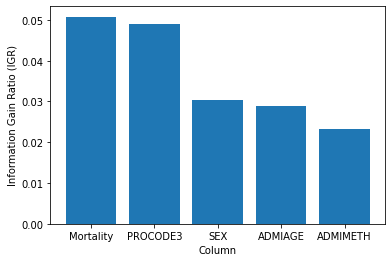

In [12]:
igr_result_sorted = dict(sorted(igr_result.items(), key=lambda kv: kv[1], reverse=True))

plt.bar(igr_result_sorted.keys(), igr_result_sorted.values())
plt.xlabel("Column")
plt.ylabel("Information Gain Ratio (IGR)")
plt.show()

## Identifying the cause of the missing data for a particular combination

As in the previous tutorial, we want to learn more about the cause of the unexpected missingness. We again select the most common missing combination with unexpected gaps (this time programatically) and apply data mining methods on the corresponding records.

To achieve this, we use the method `count_intersection()` on the `membership()` object. This returns a dataframe that contains the missingness patterns (just as the method `intersections()`) and additionally the number of records that show a particular missingness pattern (`_count`). 

Note that we only consider `combinations_with_gaps`.

In [ ]:
gaps_count = session.membership().count_intersections().loc[combinations_with_gaps]
gaps_count
# _most_freq = 
# gaps_most_freq = 
# combination_most_freq
# session.add_selection(name="gap_most_freq", intersections=combination_most_freq)

The count is used to identify the `intersection_id` for the most frequent combination with a gap. 

In [ ]:
combination_most_freq = [gaps_count["_count"].idxmax()]

We make add a selection based on the identified combination and recover the corresponding records.

In [ ]:
session.add_selection(name="gap_most_freq", intersections=combination_most_freq)
gap_most_freq_records = session.selected_records(name="gap_most_freq")

With these records we can compute the entropy as before:

In [ ]:
def entropy_table(feature: pd.Series, target: pd.Series) -> pd.DataFrame:
    df_target = pd.DataFrame({
        feature.name: feature,
        "_target": target,
    })
    df_split = (
        df_target
        .groupby(feature.name)
        .agg({"_target": ["sum", "count"]})
    )

    df_split[("_target", "p")] = (
        df_split[("_target", "sum")] / df_split[("_target", "count")]
    )

    p = df_split[("_target", "p")]
    df_split[("_target", "entropy")] = (p * np.log(1/p)).fillna(0.0)

    df_split.columns = df_split.columns.get_level_values(1)
        
    return df_split[["sum", "count", "entropy"]]

In [ ]:
entropy_table(df.loc[gaps_records, "ADMIMETH"], gap_most_freq_records)

In [ ]:
entropy_table(df.loc[gaps_records, "PROCODE3"], gap_most_freq_records)

### Decision Tree

Another way of investigating the above question is to fit a decision tree of a few levels.

First, we one-hot encode the categorical variables (`SEX` and `MORTALITY` only contain two classes, so we do not need to encode these):

In [13]:
df_enc = pd.get_dummies(df[igr_columns], columns = ["PROCODE3", "ADMIMETH"])
df_enc

,ADMIAGE,Mortality,SEX,PROCODE3_aaa,PROCODE3_abc,PROCODE3_aqw,PROCODE3_fff,PROCODE3_fgh,PROCODE3_fgl,PROCODE3_gfg,...,PROCODE3_wrd,ADMIMETH_32,ADMIMETH_34,ADMIMETH_36,ADMIMETH_37,ADMIMETH_38,ADMIMETH_39,ADMIMETH_40,ADMIMETH_65,ADMIMETH_111
0,50,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,42,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,88,1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,42,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,8,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
196,37,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
197,10,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
198,12,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Next, we fit a decision tree with Scikit Learn, using the "entropy" criterion, to split on information gain:

In [14]:
clf = tree.DecisionTreeClassifier(
    max_depth=2,
    criterion="entropy",
)
clf = clf.fit(df_enc, gaps_records)

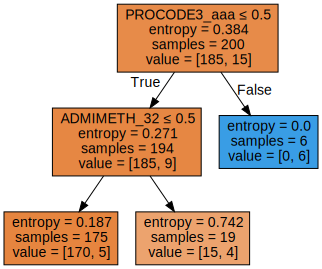

In [15]:
dot_data = tree.export_graphviz(
    clf, 
    feature_names=list(df_enc),
    filled=True,
    special_characters=True,
)
graphviz.Source(dot_data)